In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import json

import skimage, skimage.io, skimage.transform, skimage.filters
import sklearn, sklearn.metrics

import importlib

import sys
sys.path.append('../src/')
import modutils
import word_processing as wp

import datetime, time, random
import tensorflow as tf

In [2]:
def build_cnn_graph(input_shape, cnn_arch, fc_arch, num_classes):
    tf.reset_default_graph()

    with tf.name_scope('Input'):
        tf_in_x = tf.placeholder(tf.float32, shape=(None, input_shape[0], input_shape[1], 1))
        tf_in_y = tf.placeholder(tf.int32, shape=(None,))

    tf_temp = tf_in_x
    for (i, (conv_filters, conv_size, conv_stride, pool_size, pool_stride)) in enumerate(cnn_arch):
        with tf.name_scope('Conv-MaxPool-{:02d}'.format(i)):
            tf_temp = tf.layers.conv2d(tf_temp, conv_filters, conv_size, conv_stride, activation=tf.nn.relu)
            tf_temp = tf.layers.max_pooling2d(tf_temp, pool_size, pool_stride)

    with tf.name_scope('FC'):
        tf_temp = tf.contrib.layers.flatten(tf_temp)
        for sz in fc_arch:
            tf_temp = tf.layers.dense(tf_temp, sz, activation=tf.nn.elu)
            
        tf_final = tf.layers.dense(tf_temp, num_classes)
        tf_prob = tf.nn.softmax(tf_final)
        tf_predicted = tf.cast(tf.argmax(tf_prob, axis=1), dtype=tf.int32)

    with tf.name_scope('LOSS'):
        tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_in_y, logits=tf_final))
        tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
        
        tf_accuracy, tf_upd_accuracy = tf.metrics.accuracy(labels=tf_in_y, predictions=tf_predicted)
        tf_update_metrics = tf.group(tf_upd_accuracy)
        
        tfsummary_logloss = tf.summary.scalar('Log-Loss', tf_loss)
        tfsummary_accuracy = tf.summary.scalar('1-Accuracy', 1-tf_accuracy)
        tfsummary = tf.summary.merge([tfsummary_logloss, tfsummary_accuracy])

    return {'in':{'data':tf_in_x, 'label':tf_in_y},
            'out':{'logit':tf_final, 'prob':tf_prob},
            'run':{'loss': tf_loss, 'upd_metrics':tf_update_metrics,'accuracy':tf_accuracy,
                   'train': tf_train, 'summary':tfsummary}}

def make_batches(sample, batch_size):
    raw_sample = [(i,z) for (i, x) in enumerate(sample) for z in x]
    random.shuffle(raw_sample)
    num_batches = len(raw_sample) // batch_size
    return [raw_sample[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]

def get_x_value(batch, xshape):
    tres = [wp.perform_transform(src_images[x[0]], transforms_all[x[1]]) for x in batch]
    res = [x[:, :xshape] if x.shape[1] >= xshape
            else np.hstack((x, np.zeros(shape=(x.shape[0], xshape-x.shape[1]))))
            for x in tres]
    return np.array(res)

def get_y_value(batch):
    return np.array([x[0] for x in batch])

In [32]:
len(words)

0

In [35]:
src_shape = (32, 32)

graph_descr = build_cnn_graph(src_shape,
                              [(30, 5, 1, 3, 3), (200, 3, 1, 3, 3)],
                              [100], 76)
model_name = 'D03_CHAR_CNN'
tf_model_file = '../data/tfmodels/d03_char_cnn/model-13.ckpt'

print('Graph created')

batch_size  = 256
set2dict = lambda x: {graph_descr['in']['data']: x[0],
                           graph_descr['in']['label']: x[1]}

set2dict_eval = lambda x: {graph_descr['in']['data']: x}

print('Preparation complete')

Graph created
Preparation complete


In [33]:
%%time
fname = '../data/ru_calibration.json'
extraction_path = os.path.join(os.path.dirname(fname),
                               os.path.basename(fname).split('.')[0])
with open(fname, 'r', encoding='utf-8') as f:
    src = json.load(f)
    
words = wp.extract_words_from_dataset(src, (1,))

transforms_rotation = wp.generate_rotations(-10, 10, 5)
transforms_scale = wp.generate_scales(0.75, 1.25, 5)
transforms_shift = wp.generate_shifts(-0.1, 0.1, 5)
transforms_cutoff = wp.generate_cutoffs(0.3, 0.5, 5)
combinations_all = wp.generate_combinations(transforms_rotation, transforms_shift,
                                       transforms_scale, transforms_cutoff)

fixed_post = [{'type':'trimx'},{'type':'trimy'}, {'type':'resize', 'y':32}]
transforms_all = wp.append_transformations(combinations_all, post_transforms=fixed_post)

test_sample = [np.random.choice(np.arange(len(transforms_all)), size=100) for i in range(len(words))]

src_images = [skimage.io.imread(os.path.join(extraction_path, x[1]), as_grey=True) for x in words]

Wall time: 175 ms


In [34]:
len(words)

0

In [31]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tfsSaver = tf.train.Saver()

with tf.Session() as tfs:
    tfsSaver.restore(tfs, tf_model_file)
    t0 = time.perf_counter()
        
    test_res = []
    test_yf = []
    for (i, batch) in enumerate(make_batches(test_sample, batch_size)):
        print('Test batch {} of {}'.format(i * batch_size, len(test_sample)*len(test_sample[0])))
        valid_x = get_x_value(batch, src_shape[1]).reshape(-1, *src_shape, 1)
        valid_y = get_y_value(batch)
        test_yf.append(valid_y)
        test_res += modutils.runDataset(tfs, (valid_x, valid_y), batch_size, set2dict,
                                  [graph_descr['run']['loss'], graph_descr['out']['prob']])
        
    test_loss = np.sum([x[1] * x[2][0] for x in test_res]) / np.sum([x[1] for x in test_res])
    test_prob = np.concatenate([x[2][1] for x in test_res])
    test_pred = np.argmax(test_prob, axis=1)
    test_true = np.concatenate(test_yf)
    t1 = time.perf_counter()
        
print('Applied model in {:.2f} sec'.format(t1-t0))

INFO:tensorflow:Restoring parameters from ../data/tfmodels/d03_char_cnn/model-13.ckpt


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [100,0] rhs shape= [100,76]
	 [[Node: save_4/Assign_25 = Assign[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](dense_1/kernel/Adam_1, save_4/RestoreV2_25)]]

Caused by op 'save_4/Assign_25', defined at:
  File "c:\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-166bc643224c>", line 2, in <module>
    tfsSaver = tf.train.Saver()
  File "c:\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "c:\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "c:\anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "c:\anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 271, in assign
    validate_shape=validate_shape)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 45, in assign
    use_locking=use_locking, name=name)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [100,0] rhs shape= [100,76]
	 [[Node: save_4/Assign_25 = Assign[T=DT_FLOAT, _class=["loc:@dense_1/kernel"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](dense_1/kernel/Adam_1, save_4/RestoreV2_25)]]


In [23]:
sklearn.metrics.accuracy_score(test_true, test_pred)

0.99353448275862066

In [27]:
np.unique(test_true[test_true != test_pred], return_counts=True)

(array([ 9, 19, 20, 21, 22, 23, 26, 28, 31, 32, 36, 47, 52, 55, 56, 57, 58,
        60, 61, 67, 74]),
 array([1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 7, 6, 6, 3, 4, 2, 2, 1, 1], dtype=int64))

In [28]:
#53, 55, 56

In [43]:
sklearn.metrics.confusion_matrix(test_true, test_pred)[52:57, 52:57]

array([[90,  0,  0,  3,  0],
       [ 0, 99,  0,  0,  0],
       [ 0,  0, 99,  0,  0],
       [ 0,  0,  0, 94,  0],
       [ 5,  0,  0,  1, 92]])

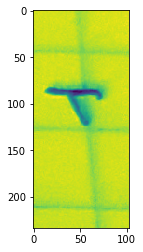

In [46]:
plt.imshow(src_images[52])

In [90]:
test_image = skimage.io.imread('../data/test01.jpg', as_grey=True)
#test_image = skimage.io.imread('../data/ru_calibration/ru_calibration/line02_word25.jpg', as_grey=True)

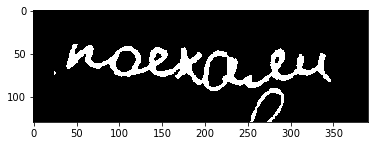

In [91]:
plt.imshow(test_image<0.54, cmap='gray')

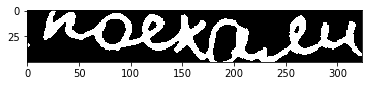

In [92]:
fin_image = wp.perform_transform(wp.trim_image_width(wp.trim_image_height(test_image<0.54)),
                                 [])[:50]*1.0
plt.imshow(fin_image, cmap='gray')

In [67]:
def extract_regions_xshift(src, xsize, xstride):
    sz = (src.shape[1] - xsize) // xstride
    offsets = [i * xstride for i in range(sz)]
    return np.array([src[:, off:(off+xsize)] for off in offsets])

In [68]:
tmp = extract_regions_xshift(fin_image, 32, 8)

In [69]:
tmp[5].shape

IndexError: index 5 is out of bounds for axis 0 with size 1

In [108]:
dt_now = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")
tfsSaver = tf.train.Saver()
xstride = 4
ystride = 4

res_ests = []
res_prob = []
res_pred = []

with tf.Session() as tfs:
    tfsSaver.restore(tfs, tf_model_file)
    t0 = time.perf_counter()
    
    num = (fin_image.shape[0] - src_shape[0]) // ystride
    print((fin_image.shape[0] - src_shape[0]), num)
    test_res = []
    for i in range(num):
        print('Step {} of {}'.format(i, num))
        off = i * ystride
        xval = extract_regions_xshift(fin_image[off:(off+src_shape[0]),:], src_shape[1], xstride)
        tmp_res = modutils.runDataset(tfs, xval.reshape(-1, *src_shape, 1),
                                        batch_size, set2dict_eval,
                                  [graph_descr['out']['logit'], graph_descr['out']['prob']])
        
        res_ests.append(np.concatenate([x[2][0] for x in tmp_res]))
        res_prob.append(np.concatenate([x[2][1] for x in tmp_res]))
        res_pred.append(np.argmax(res_prob[-1], axis=1))
    t1 = time.perf_counter()
        
print('Applied model in {:.2f} sec'.format(t1-t0))

INFO:tensorflow:Restoring parameters from ../data/tfmodels/d03_char_cnn/model-13.ckpt
18 4
Step 0 of 4
Step 1 of 4
Step 2 of 4
Step 3 of 4
Applied model in 0.24 sec


In [94]:
pred_char = np.array(res_pred)

In [106]:
pred_char.shape

(4, 73)

In [95]:
pred_conf = np.array([np.max(x, axis=1) for x in res_prob])

In [114]:
for line in range(num):
    print(' '.join(['{}:{}'.format(i,x) for (i,x) in enumerate(pred_char[line,:]) if pred_conf[line,i]>0.99995]))

13:55 38:60 58:20 59:20 60:20 68:10 69:10
10:70 11:70 33:45 58:20 59:20 72:25
7:2 11:70 41:20 42:20 43:49
39:66 50:15 51:15


In [97]:
' '.join([str(x) for x in pred_char[1,:]])

'20 58 58 44 44 40 57 61 70 70 70 70 55 55 54 49 12 18 40 40 40 32 44 14 44 44 62 40 40 32 23 58 58 25 45 45 44 60 60 62 40 70 22 60 27 27 27 27 27 14 14 14 35 43 25 25 25 20 20 20 20 62 62 40 15 15 14 10 10 10 10 10 10'

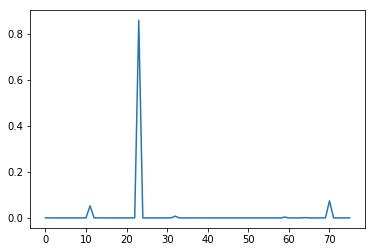

In [134]:
plt.plot(res_prob[0][30, :])

In [ ]:
п=49, о=48, e=38